In [1]:
import numpy as np
import pandas as pd

import scipy.stats as ss

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score

import catboost as catb
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Построение модели классификации

### 1. Обзор обучающего датасета


#### Описание датасета

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Пути к директориям и файлам

In [3]:
PATH = 'C:/Users/ASER/Desktop/GeekBrains/ML_project/'
TRAIN_DATASET_PATH = PATH + 'course_project_train.csv'
TEST_DATASET_PATH = PATH + 'course_project_test.csv'
PREP_DATASET_PATH = PATH + 'course_project_prep_train.csv'

### 2. Загрузка данных

In [4]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1


In [5]:
TARGET_NAME = 'Credit Default'
X = df.drop(TARGET_NAME, axis=1)
y = df[TARGET_NAME]
print('X.shape = ', X.shape)
print('y.shape = ', y.shape)

X.shape =  (7500, 16)
y.shape =  (7500,)


In [6]:
y.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [7]:
X_final = pd.read_csv(TEST_DATASET_PATH)
print('X_final.shape', X_final.shape)
X_final.head(2)

X_final.shape (2500, 16)


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0


### 3. Обработка пропусков и выбросов

* Пропуски в 'Credit Score' заполнены медианой.
* 'Years in current job' трансформированы в числовые значения от 0 до 10, пропуски заполнены медианой.
* Пропуски в 'Bankruptcies' заполнены 1, где 'Number of Credit Problems' > 0  и 0, где 'Number of Credit Problems' = 0.
* Пропуски в 'Annual Income' заполнены медианнами 30 групп, сформированных через ранжирование 'Monthly Debt'.
* В 'Current Loan Amount' значения 99999999 заполнены медианнами 30 групп, сформированных через ранжирование 'Monthly Debt'.
* В 'Maximum Open Credit' значения > 3 * 1e6 заполнены медианнами 30 групп, сформированных через ранжирование 'Current Credit Balance'.
* В 'Current Credit Balance' значения > 1.5 * 1e6 заполнены медианнами 30 групп, сформированных через ранжирование 'Maximum Open Credit'.
* Признак 'Months since last delinquent' удален, поскольку в нем больше половины пропусков.

In [8]:
class FeatureImputer:
    """Заполнение пропусков и облработка выбросов"""
    
    def __init__(self):
        self.years = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
                      '6 years', '7 years',  '8 years', '9 years', '10+ years']
        
        self.n_groups = 30        
        self.med_credit_score = None
        self.med_years_in_current_job = None
        self.med_annual_income = None
        self.med_current_loan_amount = None        
        self.med_maximum_open_credit = None
        self.med_current_credit_balance = None       
        
        
    def fit(self, X):
        
        df = X.copy()
        
        # Credit Score
        self.med_credit_score = df['Credit Score'].median()        
        
        # Years in current job            
        for i in range(len(self.years)):
            df.loc[df['Years in current job']==self.years[i],'Years in current job'] = i
               
        self.med_years_in_current_job = df['Years in current job'].median()        
        
        # Annual Income, Current Loan Amount, Maximum Open Credit, Current Credit Balance 
        t = df.shape[0] / self.n_groups
        df['monthly_debt_group'] = np.floor(ss.rankdata(df['Monthly Debt'].values) / t)
        df['current_credit_balance_group'] = np.floor(ss.rankdata(df['Current Credit Balance'].values) / t)
        df['maximum_open_credit_group'] = np.floor(ss.rankdata(df['Maximum Open Credit'].values) / t)
        
        self.med_annual_income = df.groupby(['monthly_debt_group'], 
                                            as_index=False).agg({'Annual Income':'median'})
        self.med_current_loan_amount = df.groupby(['monthly_debt_group'],
                                                 as_index=False).agg({'Current Loan Amount':'median'})
        self.med_maximum_open_credit = df.groupby(['current_credit_balance_group'],
                                                 as_index=False).agg({'Maximum Open Credit':'median'}) 
        self.med_current_credit_balance = df.groupby(['maximum_open_credit_group'],
                                                    as_index=False).agg({'Current Credit Balance':'median'})

    
    def transform(self, X):
        # 1.Credit Score
        X.loc[X['Credit Score']>1000, 'Credit Score'] /= 10
        X.loc[X['Credit Score'].isna(), 'Credit Score'] = self.med_credit_score
        
        # 2.Years in current job
        for i in range(len(self.years)):
            X.loc[X['Years in current job']==self.years[i],'Years in current job'] = i        
        
        X.loc[X['Years in current job'].isna(), 'Years in current job'] = self.med_years_in_current_job
        X['Years in current job'] = X['Years in current job'].astype(int)
        
        # 3.Bankruptcies
        X.loc[X['Bankruptcies'].isna() & (X['Number of Credit Problems'] == 0), 'Bankruptcies'] = 0
        X.loc[X['Bankruptcies'].isna() & (X['Number of Credit Problems'] > 0), 'Bankruptcies'] = 1
        
        
        # 4.Annual Income
        t0 = 0
        for i in range(self.n_groups):
            cond1 = X['Annual Income'].isna()
            if i != self.n_groups - 1:
                t1 = (self.med_annual_income.loc[i, 'Annual Income'] +\
                      self.med_annual_income.loc[i+1, 'Annual Income']) / 2 
                cond2 = (X['Monthly Debt'] >= t0) & (X['Monthly Debt'] < t1)
            else:
                cond2 = (X['Monthly Debt'] >= t0)
            X.loc[cond1 & cond2, 'Annual Income'] = self.med_annual_income.loc[i, 'Annual Income']
            t0 = t1
        
        # 5.Current Loan Amount
        t0 = 0
        for i in range(self.n_groups):
            cond1 = (X['Current Loan Amount'] == 99999999)
            if i != self.n_groups - 1:
                t1 = (self.med_current_loan_amount.loc[i, 'Current Loan Amount'] +\
                      self.med_current_loan_amount.loc[i+1, 'Current Loan Amount']) / 2 
                cond2 = (X['Monthly Debt'] >= t0) & (X['Monthly Debt'] < t1)
            else:
                cond2 = (X['Monthly Debt'] >= t0)
            X.loc[cond1 & cond2, 'Current Loan Amount'] = self.med_current_loan_amount.loc[i, 'Current Loan Amount']
            t0 = t1        
        
        # 6.Maximum Open Credit
        t0 = 0
        for i in range(self.n_groups):
            cond1 = (X['Maximum Open Credit'] > 3 * 1e6)
            if i != self.n_groups - 1:
                t1 = (self.med_maximum_open_credit.loc[i, 'Maximum Open Credit'] +\
                      self.med_maximum_open_credit.loc[i+1, 'Maximum Open Credit']) / 2 
                cond2 = (X['Current Credit Balance'] >= t0) & (X['Current Credit Balance'] < t1)
            else:
                cond2 = (X['Current Credit Balance'] >= t0)
            X.loc[cond1 & cond2, 'Maximum Open Credit'] = self.med_maximum_open_credit.loc[i, 'Maximum Open Credit']
            t0 = t1        
        
        # 7.Current Credit Balance
        t0 = 0
        for i in range(self.n_groups):
            cond1 = (X['Current Credit Balance'] > 1.5 * 1e6)
            if i != self.n_groups - 1:
                t1 = (self.med_current_credit_balance.loc[i, 'Current Credit Balance'] +\
                      self.med_current_credit_balance.loc[i+1, 'Current Credit Balance']) / 2 
                cond2 = (X['Maximum Open Credit'] >= t0) & (X['Maximum Open Credit'] < t1)
            else:
                cond2 = (X['Maximum Open Credit'] >= t0)
            X.loc[cond1 & cond2, 'Current Credit Balance'] = self.med_current_credit_balance.loc[i, 'Current Credit Balance']
            t0 = t1
            
        # 8.Months since last delinquen    
        X = X.drop('Months since last delinquent', axis=1)
        #X['Months since last delinquent'] = X['Months since last delinquent'].fillna(0)
               
        return X

In [9]:
features = FeatureImputer()
features.fit(X)
X = features.transform(X)
X_final = features.transform(X_final)

In [10]:
len(X_final) - X_final.count()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
dtype: int64

### 4. Анализ данных


In [11]:
NUMERIC_FEATURE_NAMES = [ 'Annual Income', 'Years in current job', 'Tax Liens','Number of Open Accounts',
                         'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 
                         'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                         'Credit Score']

CATEGORICAL_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Term']

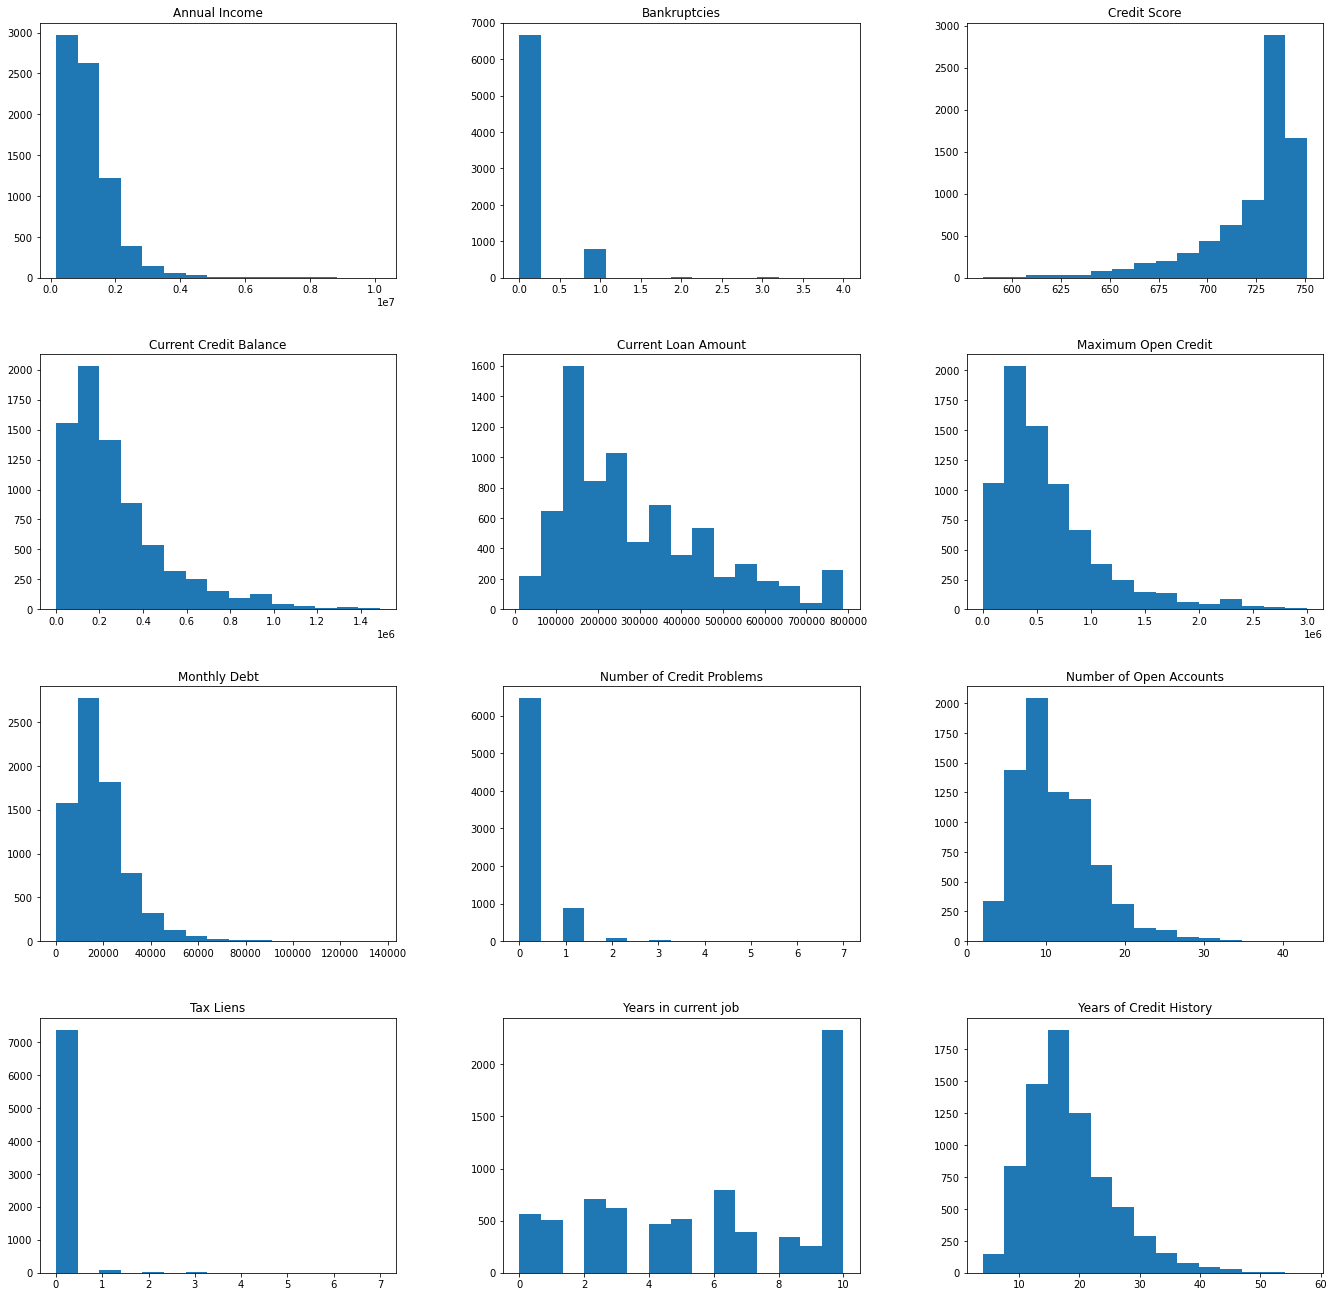

In [12]:
X.loc[:, NUMERIC_FEATURE_NAMES].hist(figsize=(23,23), bins=15, grid=False);

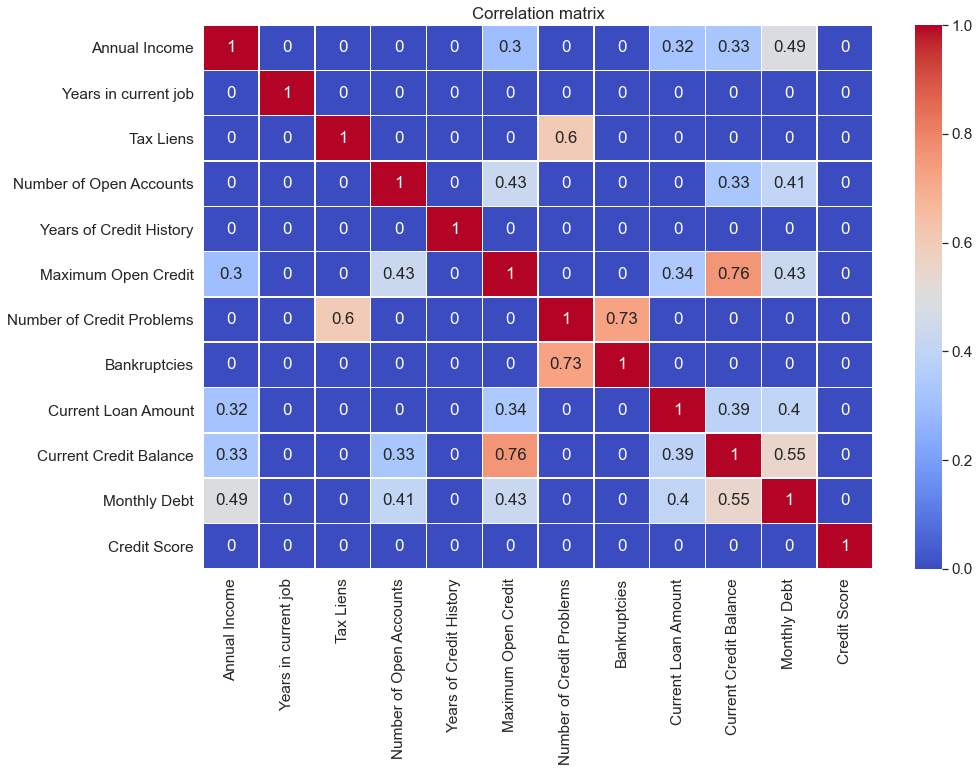

In [13]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X[NUMERIC_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.30] = 0  # убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Доля дисперсии, объясненная соответствующими компонентами: [0.26686584 0.16614957 0.09886553 0.08941091 0.07894754]



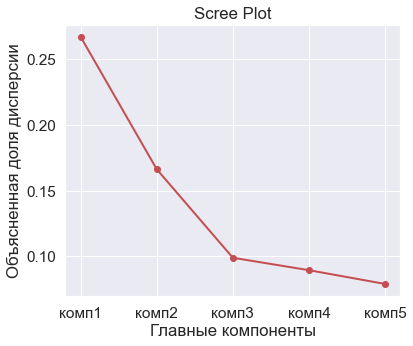



Первые 4 компонента объясяют 0.62129 дисперсии



In [14]:
scaler = StandardScaler()
a = X[NUMERIC_FEATURE_NAMES]

a = scaler.fit_transform(a)        
pca = PCA(n_components=5)
pca.fit(a)
print(f'Доля дисперсии, объясненная соответствующими компонентами: {pca.explained_variance_ratio_}\n')

fig = plt.figure(figsize=(6,5))
plt.plot(['комп1','комп2','комп3','комп4', 'комп5'], pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Главные компоненты')
plt.ylabel('Объясненная доля дисперсии')
plt.show()

print('\n')
print(f'Первые 4 компонента объясяют {round(pca.explained_variance_ratio_[:4].sum(), 5)} дисперсии\n')

### 5. Построение новых признаков

In [15]:
class FeatureGenetator():
    """Генерация новых признаков"""
               
    def transform(self, X):                
        # PCA variables
        X = self.pca_features(X) 
        
        # Dummy variables
        X = self.get_dummies(X) 
                
        return X   
        
                   
    @staticmethod    
    def get_dummies(X):
        
        # Term
        X.loc[X['Term'] == 'Short Term', 'Term'] = np.float(0)
        X.loc[X['Term'] == 'Long Term', 'Term'] = np.float(1)
        
        # Home Ownership
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        X.loc[X['Home Ownership'] == 'Home Mortgage', 'Home Ownership'] = 0
        X.loc[X['Home Ownership'] == 'Rent', 'Home Ownership'] = 1
        X.loc[X['Home Ownership'] == 'Own Home', 'Home Ownership'] = 2
        
        a = pd.get_dummies(X['Home Ownership']).rename(columns={0: 'Home Mortgage', 1: 'Rent', 2: 'Own Home'})
        X = pd.concat([X, a], axis=1).drop('Home Ownership', axis=1)
        
        # Purpose 
        data_list = X['Purpose'].unique()
        list1 = ['debt consolidation', 'other', 'home improvements', 'business loan']   
        for i in data_list:
            if not i in list1:
                X.loc[X['Purpose'] == i, 'Purpose'] = 'other'

        for i in range(len(list1)):
            X.loc[X['Purpose'] == list1[i], 'Purpose'] = i
            
        a = pd.get_dummies(X['Purpose']).rename(columns={i: list1[i] for i in range(len(list1))})   
        X = pd.concat([X, a], axis=1).drop('Purpose', axis=1)
        
        return X
    
        
    @staticmethod   
    def pca_features(X):
        scaler = StandardScaler()
        a = X[NUMERIC_FEATURE_NAMES].fillna(0)
        a = scaler.fit_transform(a)
        pca = PCA(n_components=5)
        pca.fit(a)    
        X.loc[:, 'pca_composit_1'] = np.dot(a, pca.components_.T)[:, 0]
        X.loc[:, 'pca_composit_2'] = np.dot(a, pca.components_.T)[:, 1]
        X.loc[:, 'pca_composit_3'] = np.dot(a, pca.components_.T)[:, 2]
        X.loc[:, 'pca_composit_4'] = np.dot(a, pca.components_.T)[:, 3]
        X.loc[:, 'pca_composit_5'] = np.dot(a, pca.components_.T)[:, 4]
    
        return X

In [16]:
features = FeatureGenetator()
X = features.transform(X)
X_final = features.transform(X_final)

#### Сохранение обучающего датасета

In [17]:
X.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

### 6. Отбор признаков


In [18]:
SELECTED_FEATURE_NAMES = ['Annual Income', 'Years in current job', 
                          'Number of Open Accounts', 'Years of Credit History',
                          'Maximum Open Credit', 'Number of Credit Problems', 
                          'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                          'Credit Score', 'Bankruptcies', 'Tax Liens',
                                                  
                          'pca_composit_1', 'pca_composit_2', 'pca_composit_3', 'pca_composit_4', #'pca_composit_5',  
                          'Home Mortgage', 'Rent', 
                          'Own Home',
                          'debt consolidation', 'other', 'home improvements', 'business loan',
                        ]

### 7. Балансировка классов


In [19]:
scaler = StandardScaler()

df_norm = X.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

X = df_norm.copy()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X[SELECTED_FEATURE_NAMES], y, shuffle=True, test_size=0.2, random_state=42)

#### imblearn RandomOverSampler

In [21]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_train_ros))

Original dataset shape Counter({0: 4328, 1: 1672})
Resample dataset shape Counter({0: 4328, 1: 4328})


### 8. Модель

In [22]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('roc_auc_score =', roc_auc_score(y_train_true, y_train_pred), '\n')
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('roc_auc_score =', roc_auc_score(y_test_true, y_test_pred), '\n')
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred)) 

#### CatBoostClassifier

In [23]:
model_cb = catb.CatBoostClassifier(n_estimators=300,  #default n_estimators=1000
                                                        #default max_depth=6
                                    learning_rate=0.03,                #default learning_rate=0.03
                                   silent=True, random_state=21)
model_cb.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

y_train_pred = model_cb.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model_cb.predict(X_test[SELECTED_FEATURE_NAMES])

get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

#F1 > 0.5

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      4328
           1       0.75      0.83      0.78      4328

    accuracy                           0.77      8656
   macro avg       0.78      0.77      0.77      8656
weighted avg       0.78      0.77      0.77      8656

roc_auc_score = 0.7718345656192236 

TEST

              precision    recall  f1-score   support

           0       0.81      0.66      0.73      1059
           1       0.44      0.64      0.52       441

    accuracy                           0.65      1500
   macro avg       0.63      0.65      0.62      1500
weighted avg       0.70      0.65      0.67      1500

roc_auc_score = 0.6481502893886544 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               698  361
1               160  281


#### RandomForestClassifier

In [24]:
model_rf = RandomForestClassifier(n_estimators=200,  #200
                                  max_depth=8, ### None                                  
                                  min_samples_leaf=8,
                                  random_state=42)

model_rf.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

y_train_pred = model_rf.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model_rf.predict(X_test[SELECTED_FEATURE_NAMES])

get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.72      0.76      4328
           1       0.75      0.83      0.79      4328

    accuracy                           0.78      8656
   macro avg       0.78      0.78      0.78      8656
weighted avg       0.78      0.78      0.78      8656

roc_auc_score = 0.7764556377079481 

TEST

              precision    recall  f1-score   support

           0       0.81      0.66      0.73      1059
           1       0.43      0.62      0.51       441

    accuracy                           0.65      1500
   macro avg       0.62      0.64      0.62      1500
weighted avg       0.70      0.65      0.66      1500

roc_auc_score = 0.6388904948192686 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               700  359
1               169  272


#### AdaBoostClassifier

In [25]:
model_ab = AdaBoostClassifier(n_estimators=300, 
                           random_state=42)
model_ab.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)

y_train_pred = model_ab.predict(X_train_ros[SELECTED_FEATURE_NAMES])
y_test_pred = model_ab.predict(X_test[SELECTED_FEATURE_NAMES])

get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.66      0.70      4328
           1       0.70      0.78      0.73      4328

    accuracy                           0.72      8656
   macro avg       0.72      0.72      0.72      8656
weighted avg       0.72      0.72      0.72      8656

roc_auc_score = 0.7199630314232902 

TEST

              precision    recall  f1-score   support

           0       0.80      0.62      0.70      1059
           1       0.41      0.63      0.49       441

    accuracy                           0.62      1500
   macro avg       0.60      0.62      0.59      1500
weighted avg       0.68      0.62      0.64      1500

roc_auc_score = 0.6217070397564125 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               654  405
1               165  276


#### VotingClassifier

In [26]:
model = VotingClassifier(estimators=[('cb', model_cb), ('rf', model_rf), ('ab', model_ab)],
                          voting='soft') 
model = model.fit(X_train_ros[NUMERIC_FEATURE_NAMES], y_train_ros)

y_train_pred = model.predict(X_train_ros[NUMERIC_FEATURE_NAMES])
y_test_pred = model.predict(X_test[NUMERIC_FEATURE_NAMES])

get_classification_report(y_train_ros, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.65      0.73      4328
           1       0.71      0.86      0.78      4328

    accuracy                           0.75      8656
   macro avg       0.76      0.75      0.75      8656
weighted avg       0.76      0.75      0.75      8656

roc_auc_score = 0.7541589648798522 

TEST

              precision    recall  f1-score   support

           0       0.81      0.60      0.69      1059
           1       0.41      0.67      0.51       441

    accuracy                           0.62      1500
   macro avg       0.61      0.64      0.60      1500
weighted avg       0.70      0.62      0.64      1500

roc_auc_score = 0.6358841931484587 

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               636  423
1               145  296


### 9. Интерпретация результатов

* Наиболее значчимыми признаками являются 'Current Loan Amount', 'Credit Score', 'Annual Income'.
* 'Tax Liens' - наименее значчимый признак
* Испельзуемые модели по-разному оценивают значимость признаков. На иллюстрации ниже видна разница в оценке значимости признаков моделями ExtraTreesClassifier и CatBoostClassifier. ExtraTreesClassifier дает более объективную картину.
* VotingClassifier объединяет результаты трех моделей (CatBoostClassifier, RandomForestClassifier, AdaBoostClassifier) и выбирает лучший результат.

#### ExtraTreesClassifier

Feature ranking:
1. feature 7 (0.085169)
2. feature 10 (0.076037)
3. feature 0 (0.074276)
4. feature 15 (0.070783)
5. feature 4 (0.069296)
6. feature 8 (0.067194)
7. feature 9 (0.067168)
8. feature 3 (0.065524)
9. feature 13 (0.064758)
10. feature 16 (0.064501)
11. feature 2 (0.063641)
12. feature 14 (0.061409)
13. feature 1 (0.056118)
14. feature 6 (0.033912)
15. feature 5 (0.012039)
16. feature 20 (0.011695)
17. feature 21 (0.010188)
18. feature 11 (0.009123)
19. feature 18 (0.008235)
20. feature 17 (0.008196)
21. feature 19 (0.006780)
22. feature 22 (0.006686)
23. feature 23 (0.004122)
24. feature 12 (0.003151)


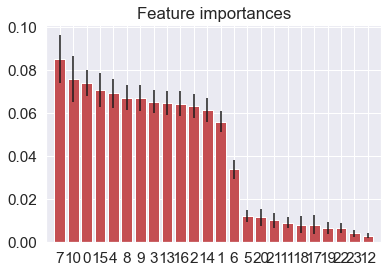

In [27]:
X = X.fillna(0)
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train_ros[SELECTED_FEATURE_NAMES], y_train_ros)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

f_list = []
for f in range(X[SELECTED_FEATURE_NAMES].shape[1]):
    f_list.append(indices[f])
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X[SELECTED_FEATURE_NAMES].shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X[SELECTED_FEATURE_NAMES].shape[1]])
plt.show()

In [28]:
list(X[SELECTED_FEATURE_NAMES].columns[f_list])

['Current Loan Amount',
 'Credit Score',
 'Annual Income',
 'pca_composit_3',
 'Maximum Open Credit',
 'Current Credit Balance',
 'Monthly Debt',
 'Years of Credit History',
 'pca_composit_1',
 'pca_composit_4',
 'Number of Open Accounts',
 'pca_composit_2',
 'Years in current job',
 'Term',
 'Number of Credit Problems',
 'debt consolidation',
 'other',
 'Bankruptcies',
 'Rent',
 'Home Mortgage',
 'Own Home',
 'home improvements',
 'business loan',
 'Tax Liens']

#### CatBoostClassifier

In [29]:
feature_importances = pd.DataFrame(zip(X[SELECTED_FEATURE_NAMES].columns,
                                       model_cb.feature_importances_ / model_cb.feature_importances_.sum()), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
7,Current Loan Amount,0.359762
0,Annual Income,0.092791
10,Credit Score,0.066313
4,Maximum Open Credit,0.053667
2,Number of Open Accounts,0.043053
8,Current Credit Balance,0.042603
3,Years of Credit History,0.042420
15,pca_composit_3,0.042225
9,Monthly Debt,0.040493
6,Term,0.039345


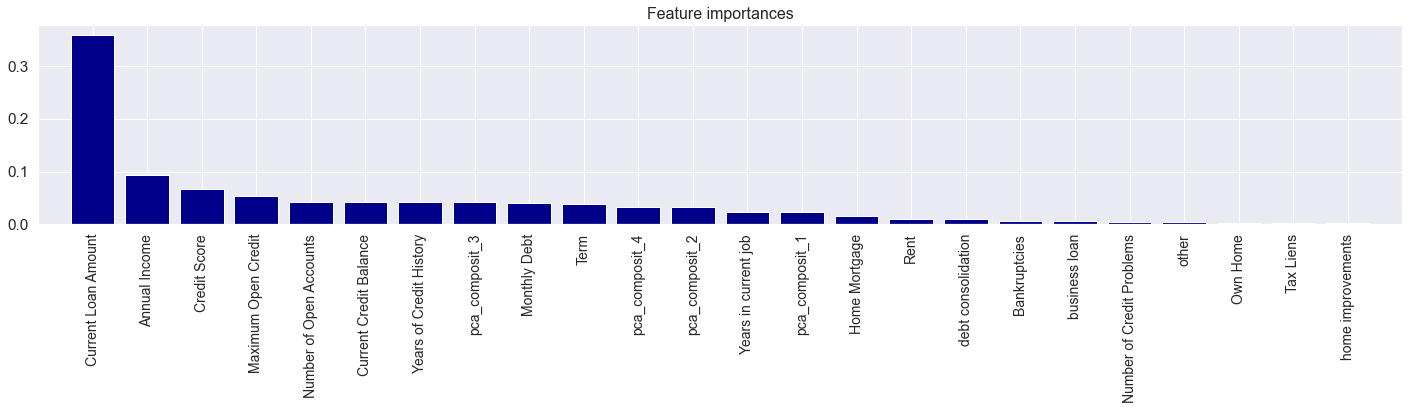

In [30]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model_cb.feature_importances_, X=X_train[SELECTED_FEATURE_NAMES])

## Прогнозирование на тестовом датасете

In [31]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

model = model.fit(X_ros[SELECTED_FEATURE_NAMES], y_ros)
print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 5387, 1: 2113})
Resample dataset shape Counter({0: 5387, 1: 5387})


In [32]:
y_pred = model.predict(X_final[SELECTED_FEATURE_NAMES])
y_final=pd.DataFrame(y_pred, columns=[TARGET_NAME])
y_final.to_csv(PATH + 'YKutovaya_predictions.csv')
y_final.head()

,Credit Default
0,0
1,0
2,0
3,0
4,0
